# Um Método Híbrido Dicotomia-Secante
## Nelson Kuhl - IME - USP
O método da dicotomia é robusto, mas converge lentamente. O método da secante converge rapidamente, desde que comecemos suficientemente próximo à raiz da função. Como não conhecemos a priori este *suficientemente próximo*, podemos combinar os métodos da dicotomia e da secante para cercar a raiz e explorar o que ambos tem de bom.

O método descrito a seguir faz isso. Ele é apresentado no livro *Fundamentals of Numerical Computing*, de L.F. Shampine, R.C. Allen, Jr. S. Pruess (John Wiley & Sons, Inc., 1997). O algoritmo calcula uma raiz de uma função contínua $f$ definida inicialmente em um intervalo $[B,C]$ tal que $f(B)*f(C)<0$. Durante as iterações, $B$ e $C$ serão modificados, sendo sempre os extremos de um intervalo cujo comprimento diminui e tais que $f(B)*f(C)<0$.

Em condições favoráveis, $B$ é calculado pelo método da secante e é uma aproximação bem melhor para a raiz do que $C$ ou do que o ponto médio do intervalo $M = (B+C)/2$. Buscando essas situações, o algoritmo troca, quando necessário, os valores de $B$ e $C$ de modo a garantir sempre que $\vert f(B)\vert \le \vert f(A)\vert$. Se a qualquer momento o valor calculado de $f(B)$ for zero, as contas são interrompidas e $B$ é identificado como uma raiz.

O teste de convergência é uma combinação de erros absoluto e relativo, especificados pelos parâmetros ABSERR e RELERR, respectivamente. As iterações param quando tivermos
$$
    \left\vert \frac{B-C}{2}\right\vert \le \max\big\{\text{ABSERR}, \vert B\vert\times\text{RELERR}\big\} = \text{TOL}.
$$
Busca-se assim aproximações com um erro relativo especificado, exceto quando a raiz é muito próxima de zero e o erro absoluto predomina.

O algoritmo usa o método da secante, exceto quando houver razão para não usá-lo. O valor de $C$ é atribuído a uma variável $A$, e as duas varáveis $A$ e $B$ são usadas como as duas iterações usadas pelo método da secante para calcular
$$
    D = B - f(B)\frac{B-A}{f(B)-f(A)}.
$$
Se o valor de $D$ cair fora do intervalo $[B,M]$ ou se a redução do tamnanho do intervalo não for satisfatória, usa-se a dicotomia. Caso contrário, $D$ é usado (exceto se estiver *muito* próximo de $B$, quando um delocamento mínimo de TOL é usado). Após decidir qual será a nova aproximação, este valor é atribuido a $B$, substituindo o valor anterior. Se $f(B)=0$, a execução é encerrada. Caso contrário, variáveis são atualizadas para a nova iteração: o antigo $B$ substitui $A$ e o antigo $C$ é mantido ou substituido pelo antigo $B$, para garantir $f(B)\cdot f(C)<0)$.

Para mais detalhes, consulte o livro mencionado acima. Todos os algoritmos do livro, em várias linguagens de programação, podem ser acessados em <blockquote>ftp.wiley.com/public/college/math/sapcodes/</blockquote> A implementação abaixo é uma adaptação para Python da subrotina ZERO contida na biblioteca saplib.f90: <blockquote>ftp.wiley.com/public/college/math/sapcodes/f90code/saplib.f90</blockquote>

In [1]:
"""
Created on Wed Apr  6 17:02:52 2022
Modifyed on MTue Apr  12 13:45:00 2022

@author: Nelson Kuhl (IME-USP) (actually pseudo author)

This function computes a root of the nonlinear equation F(x) = 0 when F(x)
is a continuous real function of a single real variable X. The method used
is a combination of bisection and secant rule, as described in Chapter 4
of the text "Fundamentals of Numerical Computing", by L.F. Shampine,
R.C. Allen, and S. Pruess. This Python implementation is an adaptation of
the Fortran 90 subroutine ZERO in the library saplib.f90:
  
  ftp.wiley.com/public/college/math/sapcodes/f90code/saplib.f90

Actually, in the address

  ftp.wiley.com/public/college/math/sapcodes/

you will find directories with all the codes of the book mentioned above in
the programming languges C, C++, Fortran77, Fortran90 and MATLAB.

*************************************

CALLING: root = zero_sap(F, B, C, ABSERR, RELERR)

  Parameters:
    F      = name of the function code defining F(X).
    B,C    = values of X such that F(B)*F(C) <= 0.
 ABSERR,RELERR = absolute and relative error tolerances.
            The stopping criterion is
                 ABS(B - C) <= 2*MAX(ABSERR,ABS(B)*RELERR).

TO DO: better output messages
---------------------
"""

def zero_sap(F, B, C, ABSERR, RELERR):

  import numpy as np
  
  UROUND = np.finfo(float).eps # Rounding unit
  MAXF = 500 # Maximum number of function evaluations
  
  # Test the input tolerances
  if ((RELERR < 10*UROUND) or (ABSERR < 0.0)):
    print("ABSERR < 0 or RELERR too small")
    return None
  
  # Initialization
  COUNT = 0 # Controls the choice for bisection
  WIDTH = abs(B - C)
  A = C
  FA = F(A)
  NUMF = 1
  if (abs(FA) <= 0.0):
    print("Root = %.9E; F = %.1F (Exact!)" % (A, 0))
    print("Number of function evaluations: %d" % NUMF)
    return A
  FB = F(B)
  NUMF = 2
  if (abs(FB) <= 0.0):
    print("Root = %.9E; F = %.1F (Exact!)" % (B, 0))
    print("Number of function evaluations: %d" % NUMF)
    return B
  if (np.sign(FA) * np.sign(FB) > 0.0):
    print("SAME SIGN AT THE INTERVAL END POINTS")
    return None
  RES = max(abs(FA), abs(FB))
  FC = FA
  
  # Main loop
  while (NUMF < MAXF):
    
    # Interchange B and C so that abs(F(B)) <= abs(F(c))
    if (abs(FC) < abs(FB)):
      A = B
      FA = FB
      B = C
      FB = FC
      C = A
      FC = FA
    
    CMB = 0.5 * (C - B)
    ACMB = abs(CMB)
    TOL = max(ABSERR, abs(B)*RELERR)
    
    # Test the stop criterium
    if (ACMB <= TOL):
      if (abs(FB) > 100*RES):
        print("Probably a pole than a root")
      print("Root = %.9E; F = %.1E" % (B, FB))
      print("Number of function evaluations: %d" % NUMF)
      return B
    
    # Calculate new iterate implicitly as B + P/Q after arranging
    # that P >= 0. The implicit form is used to prevent overflow
    P = (B - A) * FB
    Q = FA - FB
    if (P < 0.0):
      P = -P
      Q = -Q
    
    # Update A. Check if the length of the interval containing
    # a zero is being reduced at a reasonable rate, and if not,
    # bisect until it is
    A = B
    FA = FB
    COUNT += 1
    BISECT = False
    if (COUNT >= 4):
      if (8*ACMB >= WIDTH):
        BISECT = True
      else:
        COUNT = 0
        WIDTH = ACMB
    
    # Test for too small a change
    if (P <= abs(Q)*TOL):
      B = B + np.copysign(TOL, CMB) # Smallest increment alloed
    else:
      # Root ought to be between B and (C + B)/2
      if (P < CMB*Q):
        B = B + P/Q # Use secant rule
      else:
        BISECT = True # Use bisection
    
    if (BISECT):
      B = C - CMB
    
    # The new iterate B has been computed
    FB = F(B)
    NUMF += 1
    if (abs(FB) <= 0.0):
      print("Root = %.9E; F = %.1F (Exact!)" % (B, 0))
      print("Number of function evaluations: %d" % NUMF)
      return B
    
    if (np.sign(FB) * np.sign(FC) > 0.0):
      C = A
      FC = FA
    
  print("Too many (%d)iterations!" % MAXF)
  return None


### Exemplo
Como teste para o algoritmo acima, usaremos a função
$$
    f(x) = e^x - 4x^2,
$$
que possui três raízes reais nos intervalos $[-1,0]$, $[0,1]$ e $[4,5]$.

In [2]:
import numpy as np, matplotlib.pyplot as plt

In [3]:
# Definição da função
def func(x): return np.exp(x) - 4*x**2

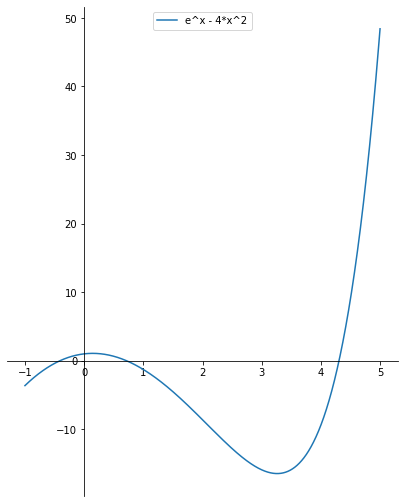

In [4]:
# Gráfico
xx = np.linspace(-1,5,6000) # pontos de -1 a 5 com espaçamento 0.001
plt.figure(figsize=((7,9)))
plt.plot(xx, func(xx), label='e^x - 4*x^2')
plt.xticks([-1, 0, 1, 2, 3, 4, 5])
# Moving spines
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))
plt.legend(loc='upper center');

In [5]:
aerr = 1.e-12; rerr = 1.e-10 # Para o critério de parada. Mude (quase) à vontade

In [6]:
# Primeira raiz
r1 = zero_sap(func, -1.0, 0.0, aerr, rerr)
r1

Root = -4.077767094E-01; F = 7.8E-16
Number of function evaluations: 11


-0.40777670940448013

In [7]:
# Segunda raiz
r2 = zero_sap(func, 0.0, 1.0, aerr, rerr)
r2

Root = 7.148059124E-01; F = 6.4E-14
Number of function evaluations: 9


0.7148059123627605

In [8]:
# Nenhuma raiz
rvoid = zero_sap(func, 1.0, 2.0, aerr, rerr)
rvoid

SAME SIGN AT THE INTERVAL END POINTS


In [9]:
# Terceira raiz
r3 = zero_sap(func, 4.0, 5.0, aerr, rerr)
r3

Root = 4.306584728E+00; F = -7.8E-09
Number of function evaluations: 9


4.306584728024759

In [10]:
# Qual raiz?
rdoubt = zero_sap(func, -1.0, 5.0, aerr, rerr)
rdoubt

Root = 4.306584728E+00; F = 6.9E-09
Number of function evaluations: 13


4.306584728395502